In [9]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
from torch.nn import functional as F  # Parameterless functions, like (some) activation functions
from torchvision.datasets import ImageFolder  # Standard datasets
from torchvision import transforms, models  # Transformations we can perform on our dataset for augmentation
import matplotlib.pyplot as plt

DEVICE = torch.device('cpu')


In [10]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
    )
])

In [11]:
train_data = ImageFolder(r'D:\Intelegenta Artificiale\Pneumonia\chest_xray\train', transform = transformations)
test_data = ImageFolder(r'D:\Intelegenta Artificiale\Pneumonia\chest_xray\test', transform = transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


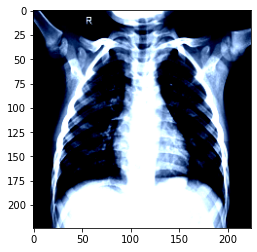

In [12]:
plt.imshow((train_data[10][0]).permute(1,2,0))

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding=1)
        
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding=1)
        
        self.pool3 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128*28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
    def forward(self,x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))
        
        out = self.flatten(out)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):
    
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        
        for example, labels in train_loader:
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)
            
            labels = labels.unsqueeze(1)
            output = model(example.float())
            loss = loss_fn(output, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0
                
                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1,1)
                    
                    outputs = model(examples.float())
                    predicted = torch.round(outputs)
                    
                    total += labels.shape[0]
                    correct +=(predicted ==labels).sum()
                accuracy[epoch] = correct/total
                
        print(f'Epoch{epoch+1})',
              f'Train Accuracy: {train_accuracy[epoch]}',
              f'Test Accuracy: {test_accuracy[epoch]}')
    if print_plot:
        
        epochs = range(n_epochs)
        
        plt.plot(epochs, train_accuracy, 'g', label = 'Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label = 'Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    

In [19]:
train_loader = DataLoader(train_data, batch_size=32, shuffle = True)
test_loader = DataLoader(test_data, batch_size=32, shuffle = True)

Epoch1) Train Accuracy: 0.9710506200790405 Test Accuracy: 0.7564102411270142
Epoch2) Train Accuracy: 0.9674080014228821 Test Accuracy: 0.745192289352417
Epoch3) Train Accuracy: 0.9827454090118408 Test Accuracy: 0.7419871687889099
Epoch4) Train Accuracy: 0.9823619723320007 Test Accuracy: 0.682692289352417
Epoch5) Train Accuracy: 0.9923312664031982 Test Accuracy: 0.7403846383094788
Epoch6) Train Accuracy: 0.9965490698814392 Test Accuracy: 0.7532051205635071
Epoch7) Train Accuracy: 0.998274564743042 Test Accuracy: 0.7179487347602844
Epoch8) Train Accuracy: 0.9986580014228821 Test Accuracy: 0.7580128312110901
Epoch9) Train Accuracy: 1.0 Test Accuracy: 0.7628205418586731
Epoch10) Train Accuracy: 1.0 Test Accuracy: 0.745192289352417


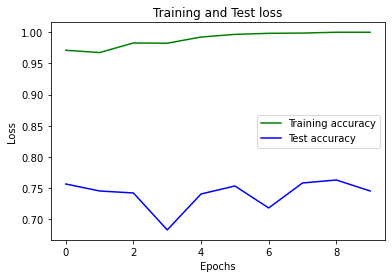

In [20]:
learning_rate = 1e-3

model = Net().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)